<a href="https://colab.research.google.com/github/cs-iuu/ocr-2025-fall-cv/blob/main/notebooks/13.1.OCR_Cyrillic_Mongolian_Tasseract.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# OCR for Cyrillic Mongolian (print)

Here is another starter code for OCR using Tasseract.

## Install dependencies

In [2]:
!pip install --upgrade pip
!pip install tensorflow pillow numpy matplotlib opencv-python pytesseract albumentations
# For Tesseract OCR baseline in Colab:
!apt-get update && apt-get install -y tesseract-ocr tesseract-ocr-rus

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 57.3 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
Hit:1 https://cli.github.com/packages stable InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,151 kB]
Get:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:

## Imports

In [3]:
# Import necessary libraries
import pytesseract
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt

# --- CONFIGURATION ---
# Set the path to the Tesseract executable if it's not in your system PATH
# Example for Windows:
# pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

# Define the language code for Mongolian (Cyrillic)
# 'mon' is the standard code for Mongolian (Cyrillic) in Tesseract
TESSERACT_LANG = 'mon'

## Preprocessing

In [4]:
def preprocess_image(image_path):
    """
    Loads an image, converts it to grayscale, and applies adaptive thresholding
    to prepare it for better OCR results.
    """
    # Load the image using OpenCV
    img = cv2.imread(image_path)

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply a blur to remove noise (optional, but often helpful)
    # blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Apply adaptive thresholding (binarization)
    # This turns the image into pure black and white, making characters clearer.
    binary = cv2.adaptiveThreshold(
        gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2
    )

    # Invert the colors if the text is white on a dark background
    # (Usually not needed for standard print)
    # binary = cv2.bitwise_not(binary)

    # Display the preprocessed image for visual check
    plt.figure(figsize=(10, 5))
    plt.imshow(binary, cmap='gray')
    plt.title("Preprocessed Image for OCR")
    plt.axis('off')
    plt.show()

    # Convert the OpenCV image (NumPy array) back to a PIL Image object
    # Tesseract's `image_to_string` often works best with PIL Image objects
    return Image.fromarray(binary)

## Define the main OCR function
Using Tesseract

In [8]:
import pandas as pd

def run_ocr_and_get_data(pil_image):
    """
    Executes Tesseract OCR and returns detailed data including bounding boxes.
    """
    custom_config = r'--oem 3 --psm 6' # Keep the same config

    # commenting out as we want to do in stages
    # # Perform the OCR
    # text = pytesseract.image_to_string(
    #     pil_image,
    #     lang=TESSERACT_LANG,
    #     config=custom_config
    # )
    # Use image_to_data to get segmentation information
    data = pytesseract.image_to_data(
        pil_image,
        lang='mon',
        config=custom_config,
        output_type=pytesseract.Output.DATAFRAME
    )

    # Clean up the DataFrame: drop rows where 'text' is NaN (often empty segmentation blocks)
    data = data.dropna(subset=['text'])

    return data

## Visualization

In [6]:
def draw_bounding_boxes(original_image_path, data_df):
    """
    Draws bounding boxes on the original image based on the OCR data.
    """
    # Load the original image using OpenCV
    img = cv2.imread(original_image_path)

    # Convert to RGB for visualization
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Filter out low-confidence entries and empty text entries
    boxes = data_df[data_df.conf > -1] # conf > -1 includes all recognized blocks, even low confidence ones

    for i in range(len(boxes)):
        # Extract coordinates
        x, y, w, h = boxes.left.iloc[i], boxes.top.iloc[i], boxes.width.iloc[i], boxes.height.iloc[i]
        text = boxes.text.iloc[i]
        level = boxes.level.iloc[i] # Segmentation level (e.g., 3=line, 4=word, 5=character)

        # Decide color and thickness based on segmentation level
        color = (255, 0, 0) # Red for Word level (level 4)
        thickness = 1

        if level == 3: # Line level
            color = (0, 255, 0) # Green for Line level
            thickness = 2

        # Draw the rectangle
        cv2.rectangle(img_rgb, (x, y), (x + w, y + h), color, thickness)

        # Optionally, draw the recognized text above the box
        cv2.putText(img_rgb, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.4, color, 1)

    # Display the image with boxes
    plt.figure(figsize=(12, 8))
    plt.imshow(img_rgb)
    plt.title("Text Detection and Segmentation")
    plt.axis('off')
    plt.show()

## Execute

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr-mon is already the newest version (1:4.00~git30-7274cfa-1.1).
0 upgraded, 0 newly installed, 0 to remove and 44 not upgraded.


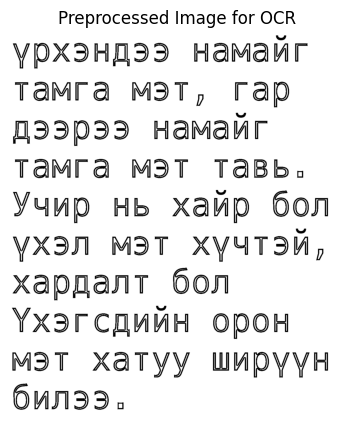

--- Segmentation Data (Bounding Boxes) ---
|   level |   page_num |   block_num |   par_num |   line_num |   word_num |   left |   top |   width |   height |   conf | text     |
|--------:|-----------:|------------:|----------:|-----------:|-----------:|-------:|------:|--------:|---------:|-------:|:---------|
|       5 |          1 |           1 |         1 |          1 |          1 |     12 |    45 |     640 |      106 |     91 | үрхэндээ |
|       5 |          1 |           1 |         1 |          1 |          2 |    757 |    14 |     467 |      110 |     96 | намайг   |
|       5 |          1 |           1 |         1 |          2 |          1 |     20 |   205 |     386 |       79 |     96 | тамга    |
|       5 |          1 |           1 |         1 |          2 |          2 |    503 |   205 |     293 |      100 |     96 | мэт,     |
|       5 |          1 |           1 |         1 |          2 |          3 |    926 |   205 |     222 |      106 |     96 | гар      |
|       5 | 

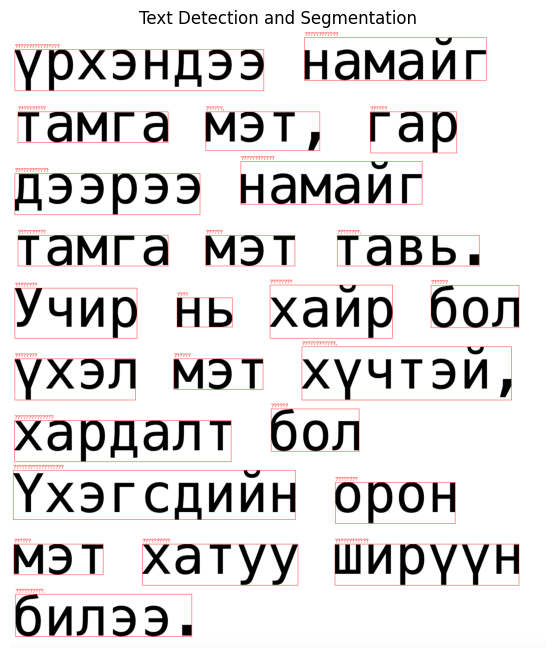

In [14]:
!
!apt-get install -y tesseract-ocr-mon

# --- MAIN EXECUTION ---
image_file = '/content/Song_of_Songs_8_6.mn.png'

# 1. Preprocess the image (re-use the function from the previous answer)
processed_img = preprocess_image(image_file)

# 2. Run OCR to get structured data
ocr_data_df = run_ocr_and_get_data(processed_img)

# 3. Print the first few rows of the data
print("--- Segmentation Data (Bounding Boxes) ---")
print(ocr_data_df[['level', 'page_num', 'block_num', 'par_num', 'line_num', 'word_num', 'left', 'top', 'width', 'height', 'conf', 'text']].head(10).to_markdown(index=False))
print("\n--- Summary of Segmentation Levels ---")
print(ocr_data_df['level'].value_counts().to_markdown())

# 4. Visualize the results
draw_bounding_boxes(image_file, ocr_data_df)